In [1]:
#Import libraries

import numpy as np
import pandas as pd
from tqdm import tqdm 
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer,MissingIndicator
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import missingno as msno
from sklearn.decomposition import PCA
from datetime import datetime
from impyute.imputation.cs import mice
from imblearn import over_sampling
%matplotlib inline

Using TensorFlow backend.


In [2]:
#Reading train and test data

data_train = pd.read_csv('/Users/kirillshcherbakov/Downloads/aps_failure_training_set.csv', header = 0, na_values = 'na')

data_test = pd.read_csv('/Users/kirillshcherbakov/Downloads/aps_failure_test_set.csv', header = 0, na_values = 'na')

In [3]:
# Observe top 10 train observations

data_train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [4]:
# Observe top 10 test observations

data_test.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,60,0.0,20.0,12.0,0.0,0.0,0.0,0.0,0.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,neg,82,0.0,68.0,40.0,0.0,0.0,0.0,0.0,0.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,neg,66002,2.0,212.0,112.0,0.0,0.0,0.0,0.0,0.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,neg,59816,NaN,1010.0,936.0,0.0,0.0,0.0,0.0,0.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,neg,1814,NaN,156.0,140.0,0.0,0.0,0.0,0.0,0.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0


In [5]:
#Encoding class target into binary variable

data_train['class'] = data_train['class'].apply(lambda x: 0 if x == 'neg' else 1)

data_test['class'] = data_test['class'].apply(lambda x: 0 if x == 'neg' else 1)

In [6]:
#Let's see number of data and number of features in train data

print('Number of data points in the train data', data_train.shape[0])
print('Number of features in the given train data', data_train.shape[1])

Number of data points in the train data 60000
Number of features in the given train data 171


In [7]:
#Let's see number of data and number of features in test data

print('Number of data points in the test data', data_test.shape[0])
print('Number of features in the given test data', data_test.shape[1])

Number of data points in the test data 16000
Number of features in the given test data 171


##Preprocessing on the train data

Text(0.5, 1.0, 'Histogram plot of class labels')

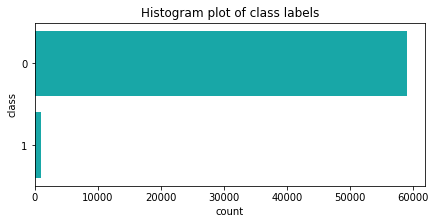

In [8]:
# Histogram plot of class labels of train dataset

f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y="class", data=data_train, color="c");
plt.title('Histogram plot of class labels')

In [9]:
#Let's see percentages on negative and positive classes

print("Percentage of negative class in the given dataset :", '{:.2f}'.format((data_train[data_train['class']== 0].shape[0] / data_train.shape[0]) * 100), '%' )
print("Percentage of positive class in the given dataset :", '{:.2f}'.format((data_train[data_train['class']== 1].shape[0] / data_train.shape[0]) * 100), '%')

Percentage of negative class in the given dataset : 98.33 %
Percentage of positive class in the given dataset : 1.67 %


In [10]:
# Count number of unique values in every column

train_nunique_dict = data_train.nunique().to_dict()
train_nunique_dict

{'class': 2,
 'aa_000': 22095,
 'ab_000': 29,
 'ac_000': 2061,
 'ad_000': 1886,
 'ae_000': 333,
 'af_000': 418,
 'ag_000': 154,
 'ag_001': 617,
 'ag_002': 2422,
 'ag_003': 7879,
 'ag_004': 23071,
 'ag_005': 40797,
 'ag_006': 40615,
 'ag_007': 32125,
 'ag_008': 18932,
 'ag_009': 5355,
 'ah_000': 43571,
 'ai_000': 4055,
 'aj_000': 894,
 'ak_000': 159,
 'al_000': 9017,
 'am_0': 10582,
 'an_000': 48204,
 'ao_000': 47723,
 'ap_000': 44672,
 'aq_000': 34921,
 'ar_000': 68,
 'as_000': 21,
 'at_000': 3511,
 'au_000': 56,
 'av_000': 3860,
 'ax_000': 2215,
 'ay_000': 466,
 'ay_001': 919,
 'ay_002': 986,
 'ay_003': 1032,
 'ay_004': 1767,
 'ay_005': 19696,
 'ay_006': 34628,
 'ay_007': 38651,
 'ay_008': 37822,
 'ay_009': 447,
 'az_000': 9184,
 'az_001': 7378,
 'az_002': 9064,
 'az_003': 21530,
 'az_004': 34077,
 'az_005': 44601,
 'az_006': 12306,
 'az_007': 3876,
 'az_008': 1271,
 'az_009': 336,
 'ba_000': 44840,
 'ba_001': 40164,
 'ba_002': 35958,
 'ba_003': 32914,
 'ba_004': 30673,
 'ba_005': 295

In [11]:
#To go futher let's split target and features

y_train = data_train['class']

data_train.drop(['class'],axis = 1,inplace = True)

In [12]:
# Replacing the na and nan values with np.NaN

data_train.replace(to_replace= 'nan', value = np.NaN,inplace = True)
data_train.replace(to_replace = 'na', value = np.NaN, inplace = True)

In [13]:
col_names = data_train.columns
col_names

Index(['aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000',
       'ag_001', 'ag_002', 'ag_003',
       ...
       'ee_002', 'ee_003', 'ee_004', 'ee_005', 'ee_006', 'ee_007', 'ee_008',
       'ee_009', 'ef_000', 'eg_000'],
      dtype='object', length=170)

Let's plot to see the number of missing values in each column of the train data,
because when we saw the data after uploading we indicated a lot of missing values and the idea to drop columns with a big number of missing values is appeared

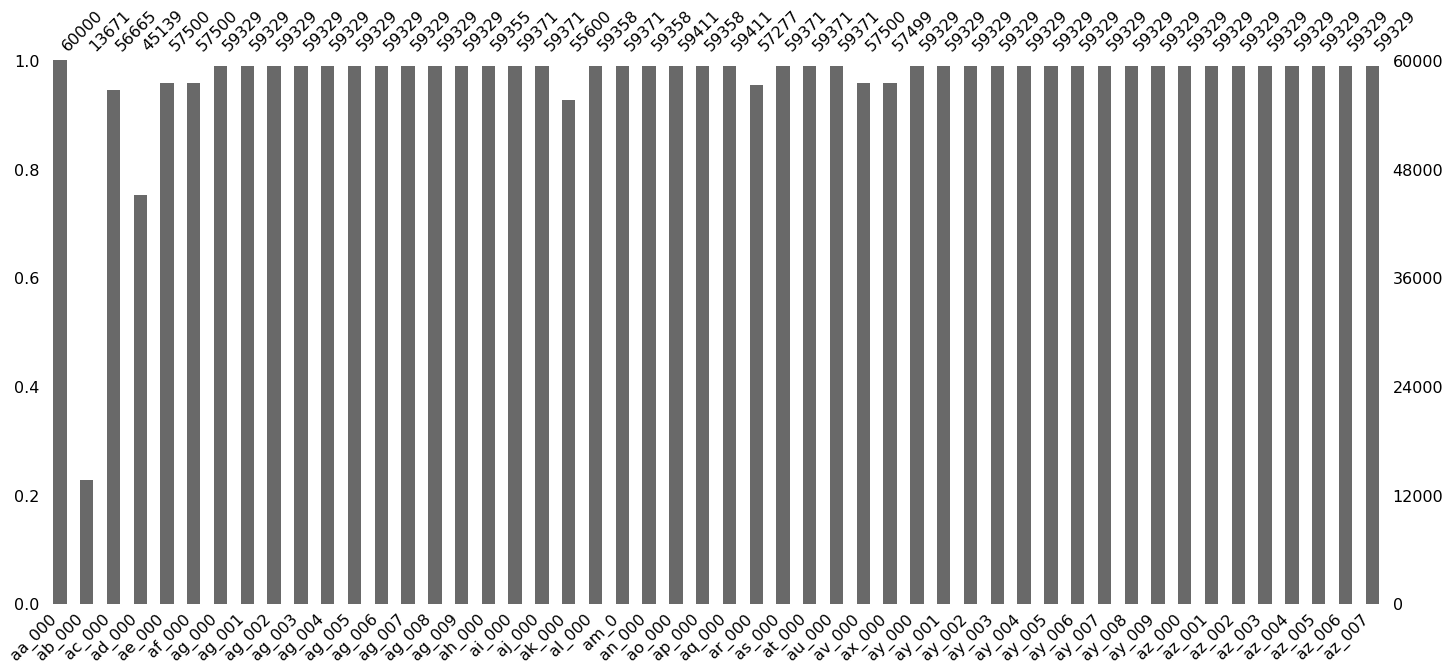

In [14]:
# plot to see the number of missing values in each column of the train data

msno.bar(data_train[col_names[0:50]])

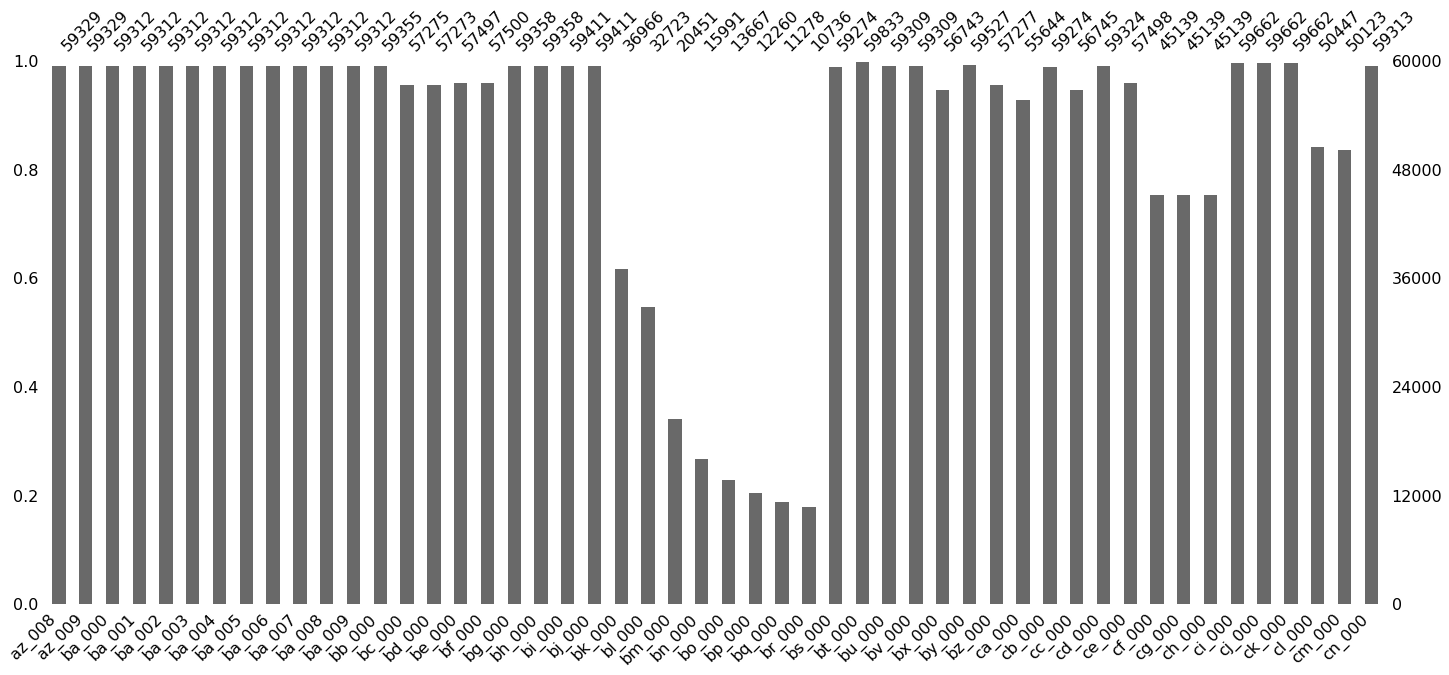

In [15]:
msno.bar(data_train[col_names[50:100]])

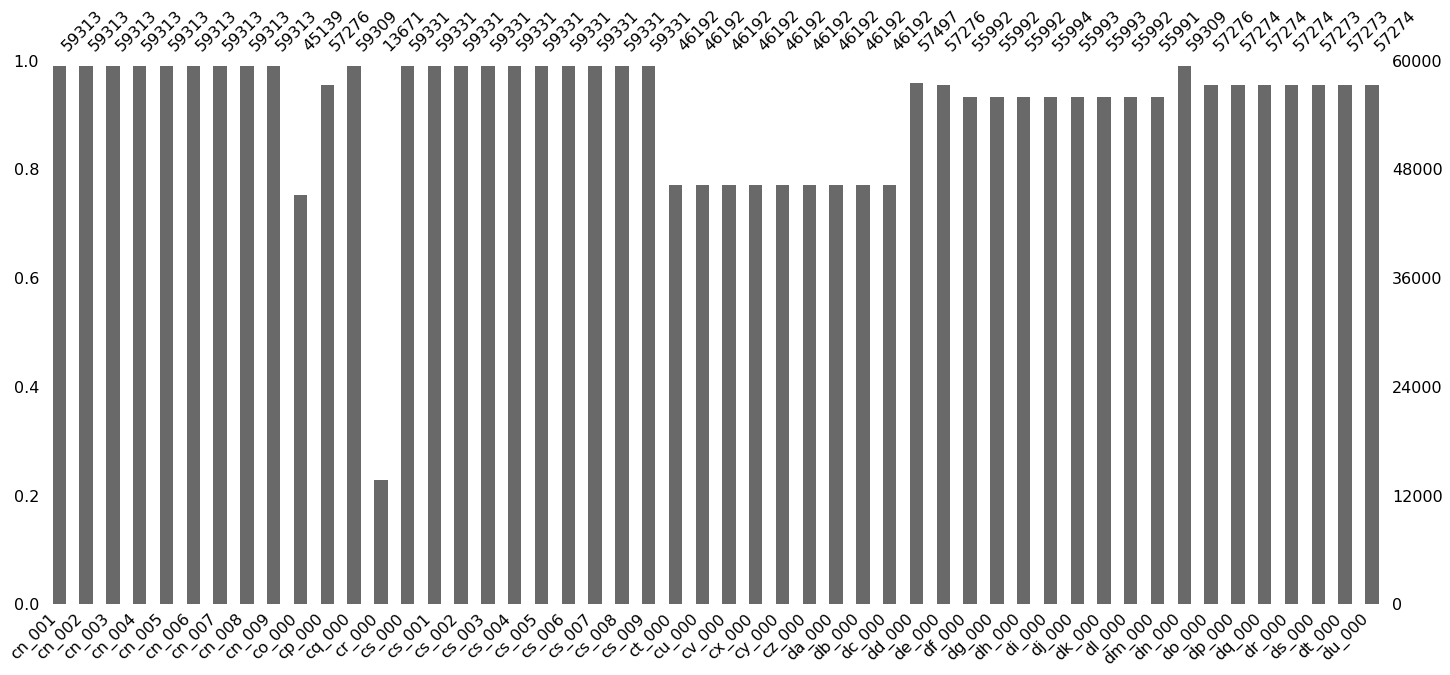

In [16]:
msno.bar(data_train[col_names[100:150]])

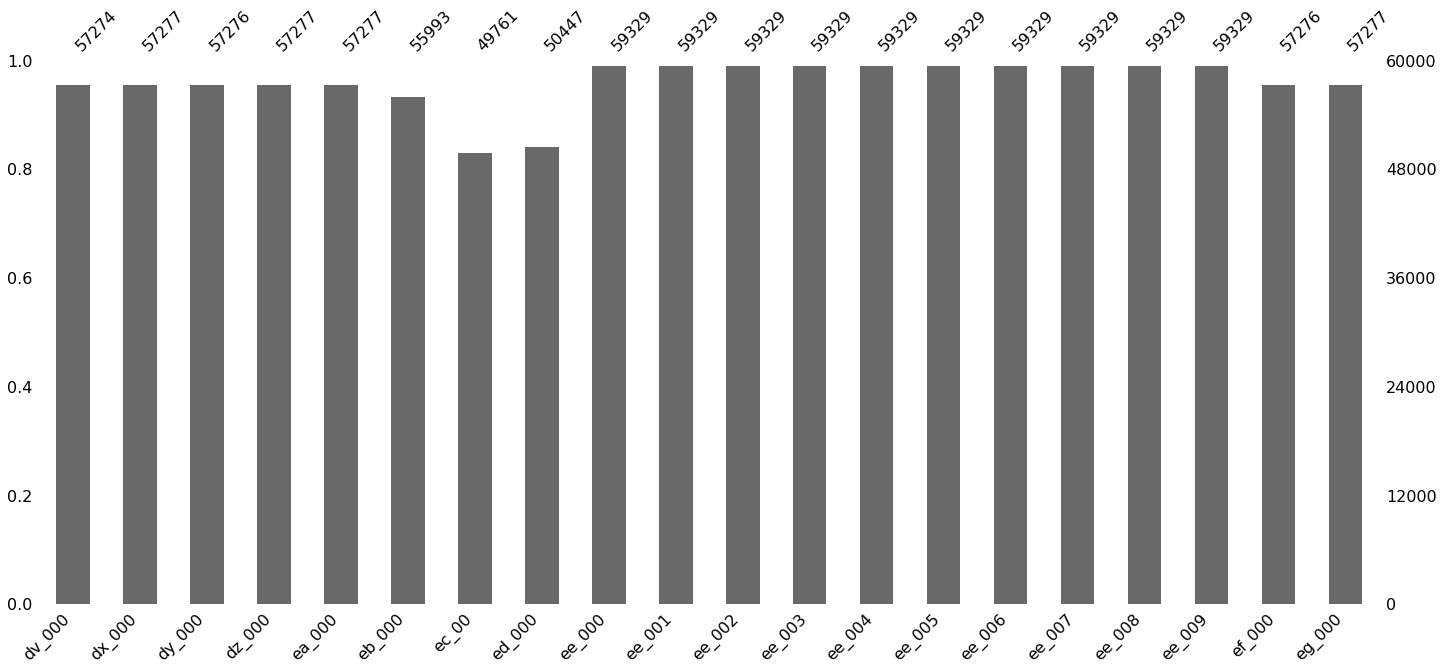

In [17]:
msno.bar(data_train[col_names[150:170]])

We see that about 7 columns have missing values of more than 60%. Our idea is to get rid of them as they are probably useless because there is very little information in them due to the large number of missing values.

In [18]:
#Let's count values which are not NaN

train_values = data_train.count()
train_values

aa_000    60000
ab_000    13671
ac_000    56665
ad_000    45139
ae_000    57500
          ...  
ee_007    59329
ee_008    59329
ee_009    59329
ef_000    57276
eg_000    57277
Length: 170, dtype: int64

In [19]:
#Dropping columns with more than 60% missing values
volume = 0.4 

col_with_most_missing = [x for x in train_values.index if train_values[x] <= volume*data_train.shape[0]]
data_train_d = data_train.drop(col_with_most_missing,axis=1)

In [20]:
#Let's compare dropped columns and visual columns that have more than 60% missing values

col_with_most_missing

['ab_000',
 'bm_000',
 'bn_000',
 'bo_000',
 'bp_000',
 'bq_000',
 'br_000',
 'cr_000']

In [21]:
data_train_d.shape

(60000, 162)

Let's plot four the most correlated features

/Users/kirillshcherbakov/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/kirillshcherbakov/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/kirillshcherbakov/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/kirillshcherbakov/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


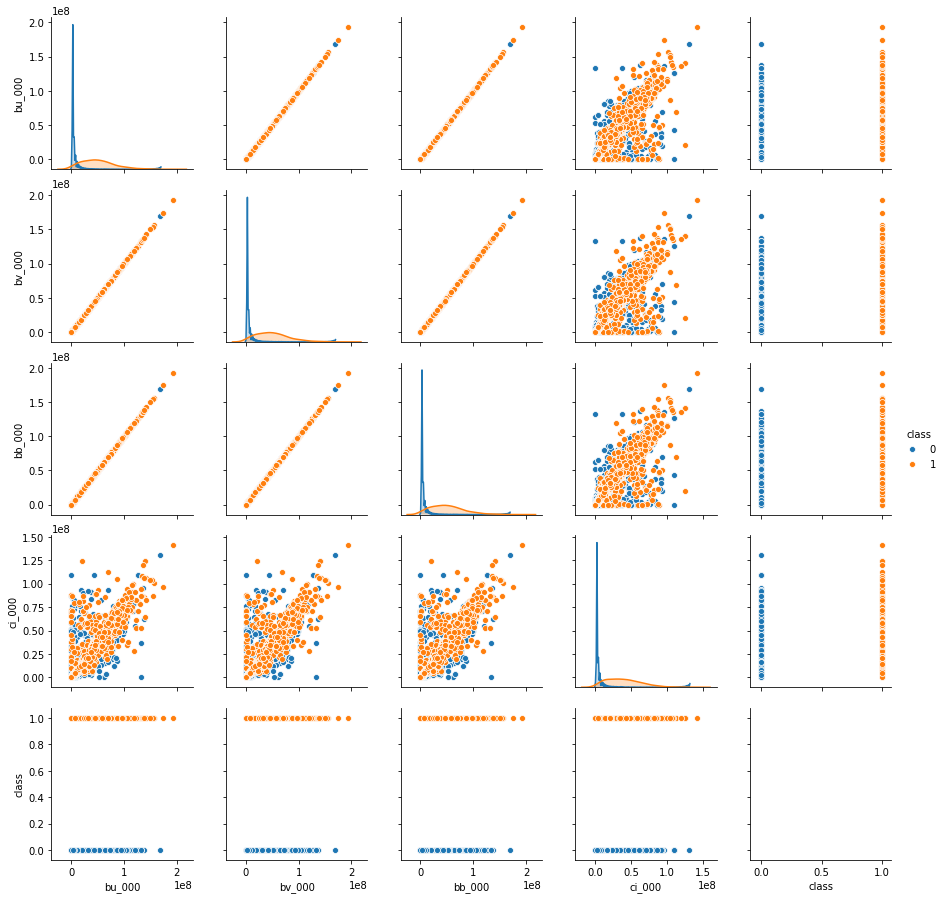

In [22]:
data_train_d_plt = data_train_d
data_train_d_plt['class'] = y_train

matrix_corr = data_train_d_plt.corr() 
matrix_corr.drop(['class'],axis=0,inplace=True) 
four_most_correlated = matrix_corr['class'].sort_values()[-5:-1]
 
four_m_c_list = (list(four_most_correlated.index)) 
four_m_c_list.append('class')
 
sns.pairplot(data = data_train_d_plt[four_m_c_list],hue='class')

Let's build correlation matrix

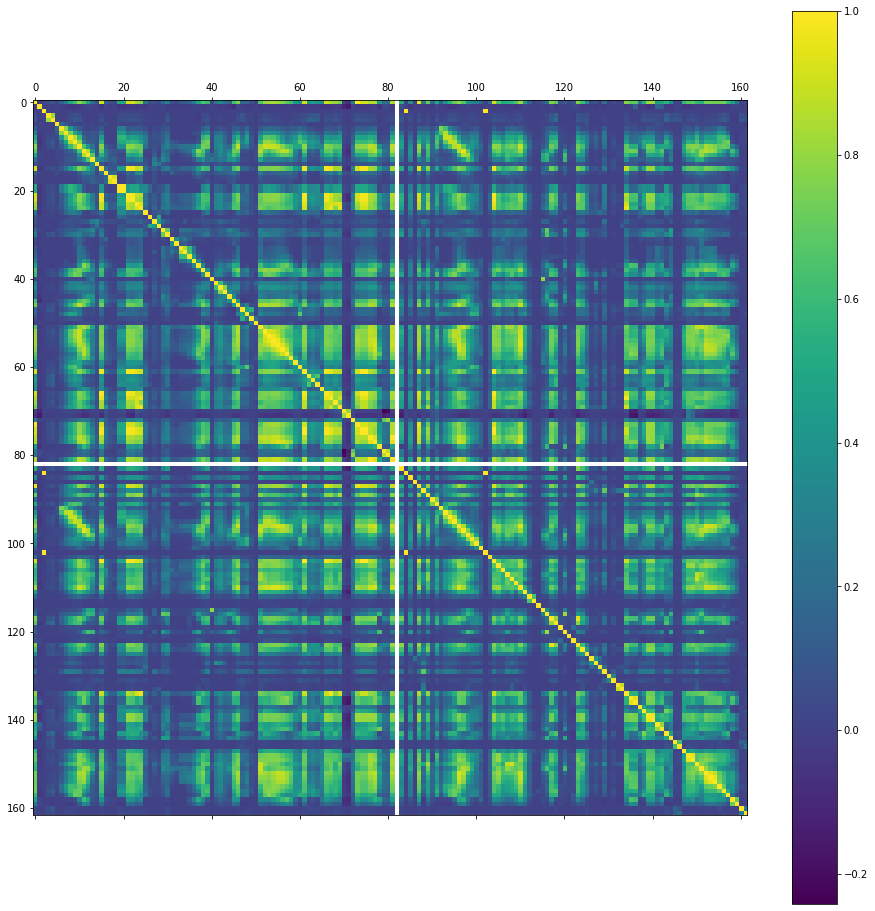

In [23]:
data_train_d_plt_matrix = data_train_d_plt.drop(['class'], axis=1)

corr_mat = data_train_d_plt_matrix.corr()

# for example plot corr matrix with target 
plt.rcParams["figure.figsize"] = (50, 30)
plt.matshow(corr_mat)
plt.colorbar()
plt.show()

Let's see the correlation values of each features on the target

In [24]:
corr_on_class= data_train_d_plt.corrwith(data_train_d_plt['class'])
corr_on_class_dict = corr_on_class.to_dict()

In [25]:
#removing the key of target
def removekey(d, key):
    r = dict(d)
    del r[key]
    return r
  
corr_on_class_dict = removekey(corr_on_class_dict, 'class')

In [26]:
import operator
sorted_dict1 = sorted(corr_on_class_dict.items(), key=operator.itemgetter(1))

Text(0.5, 1.0, 'Correlation value on class ')

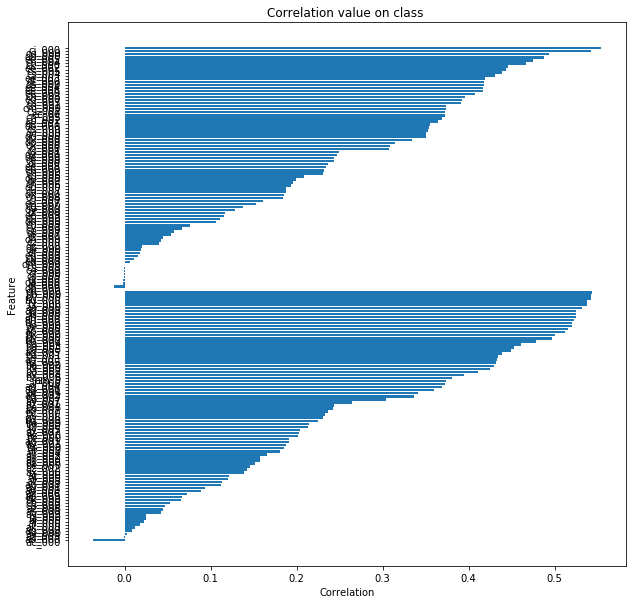

In [28]:
#Plot correlation on class
plt.figure(figsize=(10,10)) 
plt.barh(list(map(lambda x: x[0],sorted_dict1)), list(map(lambda x: x[1],sorted_dict1))) 
plt.xlabel('Correlation') 
plt.ylabel('Feature') 
plt.title('Correlation value on class ')

It's good to see distribution of unqiue values on each feature

Text(0.5, 1, 'Distribution of unique feature values')

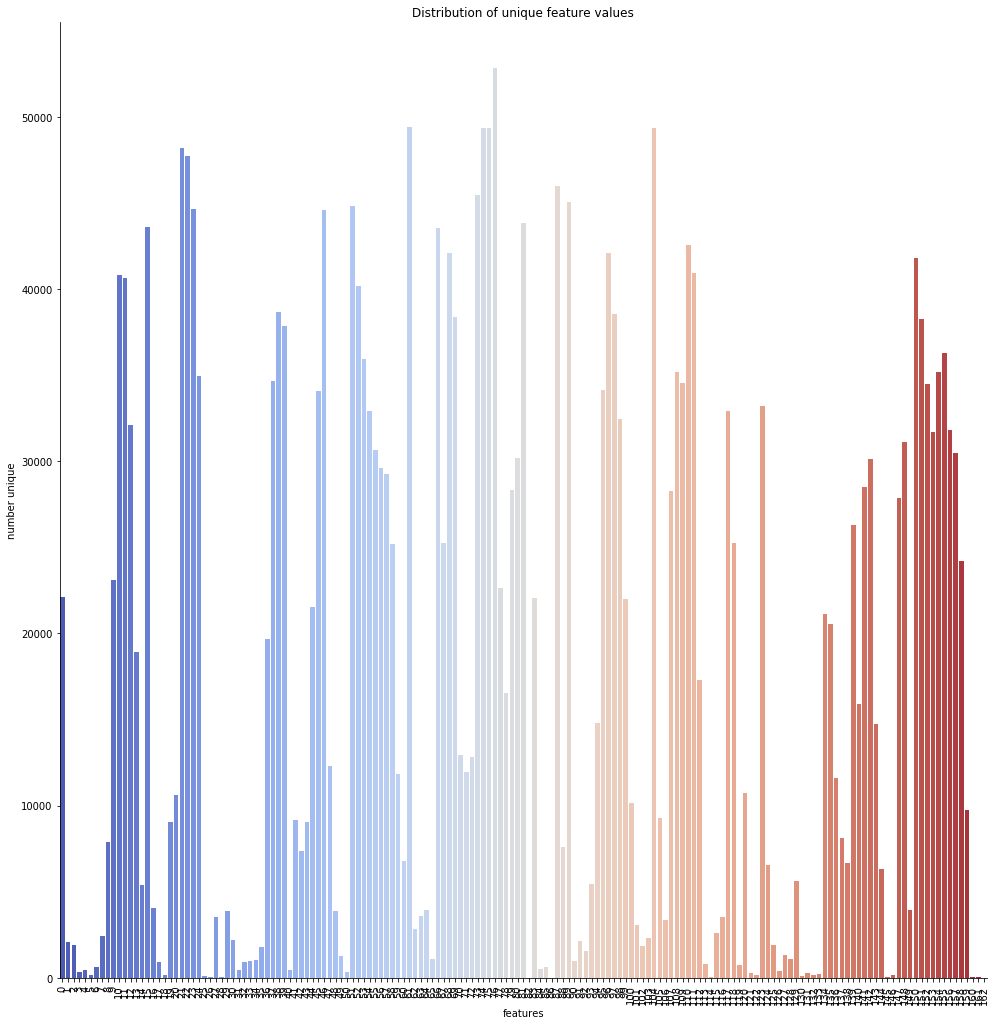

In [313]:
#Plotting unique values on features

number_unique = {x:len(pd.unique(data_train_d[x])) for x in data_train_d.columns}
 
data_unique = {'features':list(range(163)),'number unique':list(number_unique.values())}
 
unique_data = pd.DataFrame(data_unique)
custom_palette = ['#FBB4AE', '#B3CDE3', '#CCEBC5', '#DECBE4', '#FED9A6', '#FFFFCC', '#E5D8BD', '#FDDAEC', '#F2F2F2']

sns.catplot(x='features',y='number unique',data=unique_data,height=14, kind="bar", palette = sns.color_palette("coolwarm", 163)) 
plt.xticks(rotation = 'vertical')
plt.title('Distribution of unique feature values')

Now let's estimate visually quantity and an arrangement of the missed values (there are missed values one after another or appear like inserts)

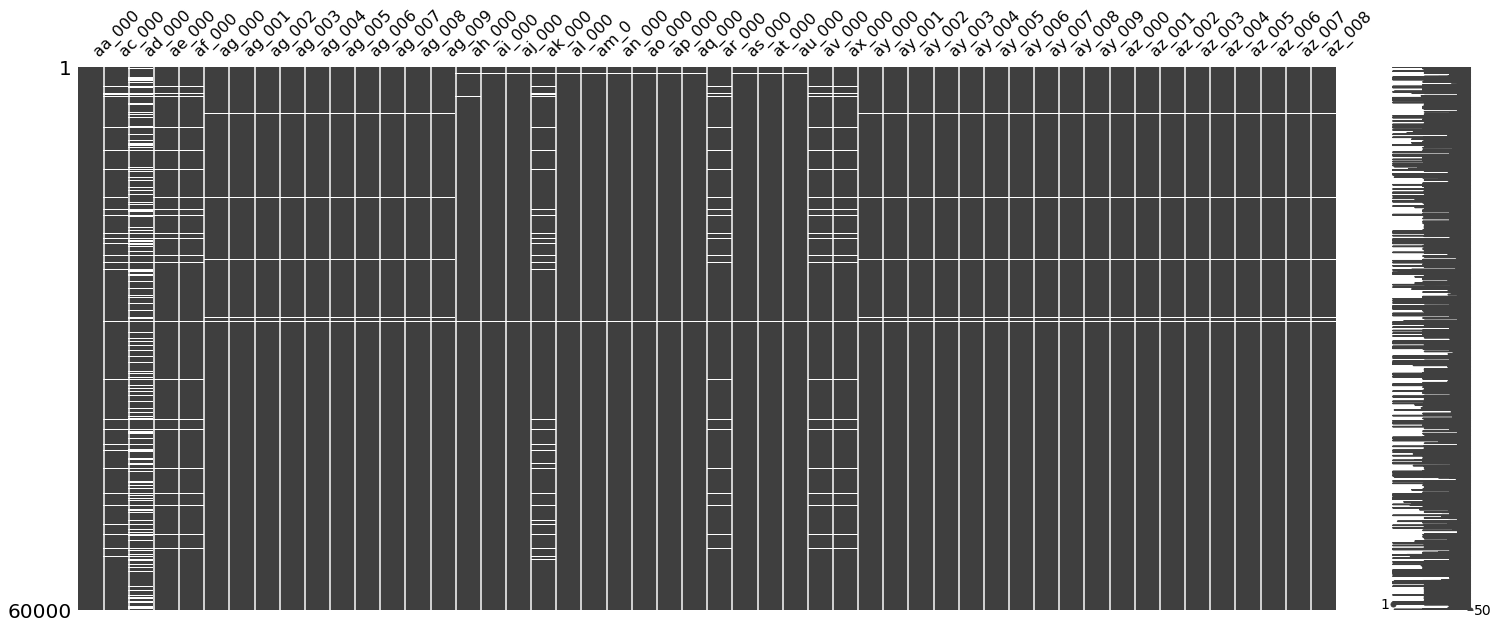

In [115]:
col_names_d = data_train_d.columns

msno.matrix(data_train_d[col_names_d[0:50]])

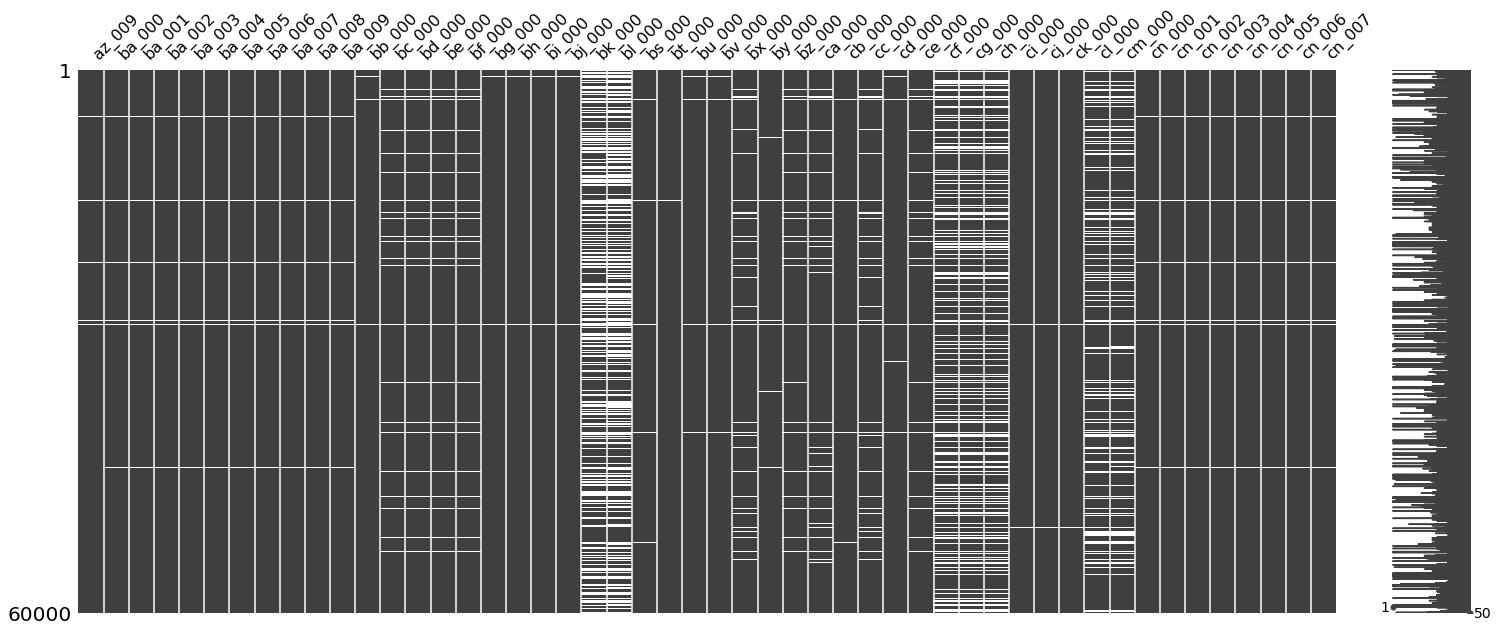

In [116]:
msno.matrix(data_train_d[col_names_d[50:100]])

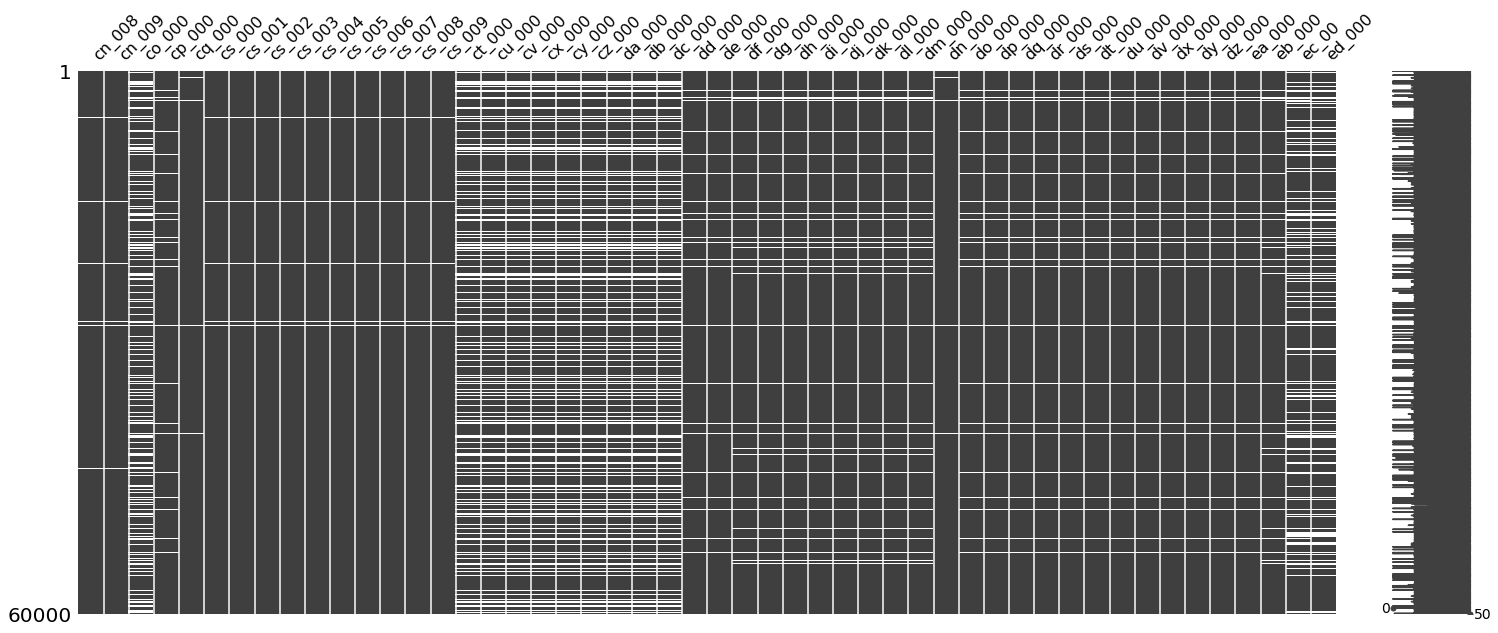

In [117]:
msno.matrix(data_train_d[col_names_d[100:150]])

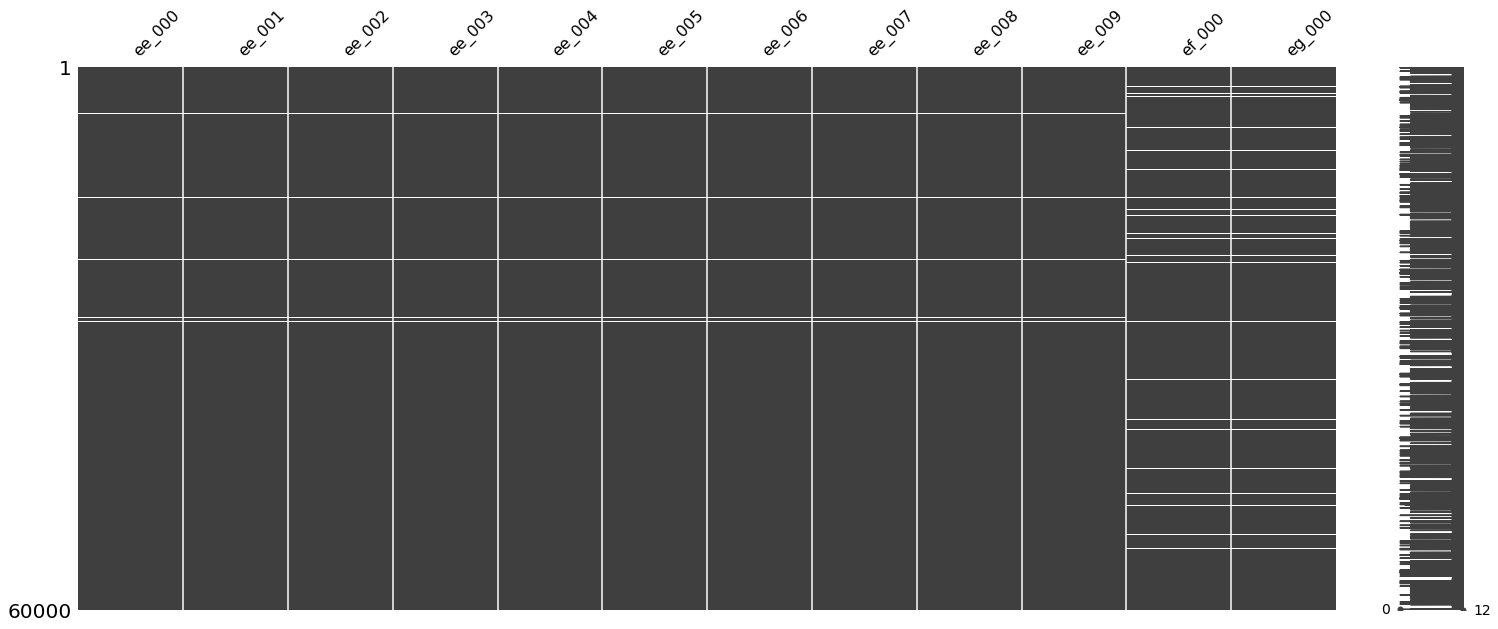

In [118]:
msno.matrix(data_train_d[col_names_d[150:162]])

After removing all columns with missing values more than 60%, we now have 162 columns. Let's use different imputation techniques are used to replace all the missing values. After analyzing an article [1] that tested median, mean, and the most common value imputation techniques, they state that median imputation technique yields the best results on RandomForestClassifier and LogisticRegression.

Source [1]: https://www.researchgate.net/publication/309195602_Prediction_of_Failures_in_the_Air_Pressure_System_of_Scania_Trucks_Using_a_Random_Forest_and_Feature_Engineering


In [119]:
# Imputation using median

impute_median = SimpleImputer(missing_values= np.nan, strategy='median',copy = True, verbose= 10)
train_impMedian = pd.DataFrame(impute_median.fit_transform(data_train_d),columns=col_names_d)

##Preprocessing on the test data

In [122]:
# Distrubution of class labels in train dataset

data_test['class'].value_counts()

0    15625
1      375
Name: class, dtype: int64

In [123]:
data_test.shape

(16000, 171)

Text(0.5, 1.0, 'Histogram plot of class labels')

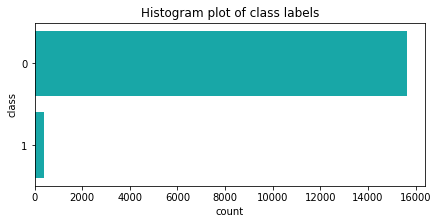

In [124]:
# Histogram plot of class labels of train dataset

f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y="class", data=data_test, color="c");
plt.title('Histogram plot of class labels')

In [125]:
# Separate target and features

y_test = data_test['class']
data_test.drop(['class'],axis =1, inplace= True)

In [126]:
# Replacing the na and nan values with np.NaN

data_test.replace(to_replace='nan', value = np.NaN,inplace = True)
data_test.replace(to_replace = 'na', value = np.NaN, inplace = True)

In [127]:
data_test.shape

(16000, 170)

In [128]:
y_test.value_counts()

0    15625
1      375
Name: class, dtype: int64

In [129]:
data_test_d = data_test[data_train_d.columns]
data_test_d

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,60,2.000000e+01,12.0,0.0,0.0,0.0,0.0,0.0,2682.0,4736.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,82,6.800000e+01,40.0,0.0,0.0,0.0,0.0,0.0,0.0,748.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,66002,2.120000e+02,112.0,0.0,0.0,0.0,0.0,0.0,199486.0,1358536.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,59816,1.010000e+03,936.0,0.0,0.0,0.0,0.0,0.0,0.0,123922.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,1814,1.560000e+02,140.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,81852,2.130706e+09,892.0,0.0,0.0,0.0,0.0,0.0,0.0,5486.0,...,632658.0,273242.0,510354.0,373918.0,349840.0,317840.0,960024.0,25566.0,0.0,0.0
15996,18,5.200000e+01,46.0,8.0,26.0,0.0,0.0,0.0,0.0,6444.0,...,266.0,44.0,46.0,14.0,2.0,0.0,0.0,0.0,0.0,0.0
15997,79636,1.670000e+03,1518.0,0.0,0.0,0.0,0.0,0.0,0.0,15062.0,...,806832.0,449962.0,778826.0,581558.0,375498.0,222866.0,358934.0,19548.0,0.0,0.0
15998,110,3.600000e+01,32.0,0.0,0.0,0.0,0.0,0.0,0.0,198.0,...,588.0,210.0,180.0,544.0,1004.0,1338.0,74.0,0.0,0.0,0.0


In [130]:
data_train_d

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,0.0,37250.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,33058,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,18254.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,41040,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,0.0,1648.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,12,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,318.0,2212.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,60874,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,0.0,43752.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,153002,6.640000e+02,186.0,0.0,0.0,0.0,0.0,0.0,2564.0,59100.0,...,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0
59996,2286,2.130707e+09,224.0,0.0,0.0,0.0,0.0,0.0,0.0,104.0,...,10578.0,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0,0.0,0.0
59997,112,2.130706e+09,18.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,...,792.0,386.0,452.0,144.0,146.0,2622.0,0.0,0.0,0.0,0.0
59998,80292,2.130706e+09,494.0,0.0,0.0,0.0,0.0,0.0,0.0,330.0,...,699352.0,222654.0,347378.0,225724.0,194440.0,165070.0,802280.0,388422.0,0.0,0.0


In [131]:
# Median Imputation
test_impMedian = pd.DataFrame(impute_median.transform(data_test_d), columns=col_names_d)

In [132]:
test_impMedian

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,60.0,2.000000e+01,12.0,0.0,0.0,0.0,0.0,0.0,2682.0,4736.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,82.0,6.800000e+01,40.0,0.0,0.0,0.0,0.0,0.0,0.0,748.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,66002.0,2.120000e+02,112.0,0.0,0.0,0.0,0.0,0.0,199486.0,1358536.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,59816.0,1.010000e+03,936.0,0.0,0.0,0.0,0.0,0.0,0.0,123922.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,1814.0,1.560000e+02,140.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,81852.0,2.130706e+09,892.0,0.0,0.0,0.0,0.0,0.0,0.0,5486.0,...,632658.0,273242.0,510354.0,373918.0,349840.0,317840.0,960024.0,25566.0,0.0,0.0
15996,18.0,5.200000e+01,46.0,8.0,26.0,0.0,0.0,0.0,0.0,6444.0,...,266.0,44.0,46.0,14.0,2.0,0.0,0.0,0.0,0.0,0.0
15997,79636.0,1.670000e+03,1518.0,0.0,0.0,0.0,0.0,0.0,0.0,15062.0,...,806832.0,449962.0,778826.0,581558.0,375498.0,222866.0,358934.0,19548.0,0.0,0.0
15998,110.0,3.600000e+01,32.0,0.0,0.0,0.0,0.0,0.0,0.0,198.0,...,588.0,210.0,180.0,544.0,1004.0,1338.0,74.0,0.0,0.0,0.0


##Logistic Regression using Median Impute

In [133]:
train_impMedian['class'] = y_train

In [134]:
train_impMedian

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,class
0,76698.0,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,0.0,37250.0,...,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0,0
1,33058.0,0.000000e+00,126.0,0.0,0.0,0.0,0.0,0.0,0.0,18254.0,...,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0,0
2,41040.0,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,0.0,1648.0,...,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0,0
3,12.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,318.0,2212.0,...,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0,0
4,60874.0,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,0.0,43752.0,...,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,153002.0,6.640000e+02,186.0,0.0,0.0,0.0,0.0,0.0,2564.0,59100.0,...,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0,0
59996,2286.0,2.130707e+09,224.0,0.0,0.0,0.0,0.0,0.0,0.0,104.0,...,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0,0.0,0.0,0
59997,112.0,2.130706e+09,18.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,...,386.0,452.0,144.0,146.0,2622.0,0.0,0.0,0.0,0.0,0
59998,80292.0,2.130706e+09,494.0,0.0,0.0,0.0,0.0,0.0,0.0,330.0,...,222654.0,347378.0,225724.0,194440.0,165070.0,802280.0,388422.0,0.0,0.0,0


In [135]:
#Undersampling the negative class

train_neg_sampled = train_impMedian[train_impMedian['class'] == 0].sample(n = 10000,random_state = 42)
train_Sampled = train_impMedian[train_impMedian['class'] == 1].append(train_neg_sampled)

In [136]:
print("Shape of the train data after under sampling the negative class", train_Sampled.shape[0])

Shape of the train data after under sampling the negative class 11000


In [137]:
train_Sampled

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,class
9,153204.0,1.820000e+02,126.0,0.0,0.0,0.0,0.0,0.0,11804.0,684444.0,...,26872.0,34044.0,22472.0,34362.0,0.0,0.0,0.0,0.0,0.0,1
23,453236.0,2.926000e+03,126.0,0.0,0.0,0.0,0.0,222.0,323436.0,2999280.0,...,3026002.0,5025350.0,2025766.0,1160638.0,533834.0,493800.0,6914.0,0.0,0.0,1
60,72504.0,1.594000e+03,1052.0,0.0,0.0,0.0,244.0,178226.0,1249396.0,3813464.0,...,372252.0,527514.0,358274.0,332818.0,284178.0,3742.0,0.0,0.0,0.0,1
115,762958.0,1.520000e+02,126.0,0.0,0.0,776.0,281128.0,2186308.0,8123016.0,18022646.0,...,112086.0,221518.0,189988.0,92432.0,41098.0,3812.0,0.0,0.0,0.0,1
135,695994.0,1.520000e+02,126.0,0.0,0.0,0.0,0.0,0.0,55620.0,1190014.0,...,495544.0,361646.0,28610.0,5130.0,212.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56472,38300.0,5.880000e+02,550.0,0.0,0.0,0.0,0.0,0.0,0.0,65354.0,...,134706.0,252728.0,278584.0,194686.0,169626.0,282316.0,20252.0,0.0,0.0,0
24100,47980.0,7.000000e+01,66.0,0.0,0.0,0.0,0.0,0.0,0.0,80908.0,...,210418.0,521896.0,518492.0,298242.0,153558.0,129412.0,290.0,0.0,0.0,0
22879,42002.0,1.196000e+03,126.0,0.0,0.0,0.0,0.0,0.0,0.0,274.0,...,226528.0,431696.0,314668.0,221120.0,118500.0,98848.0,842.0,0.0,0.0,0
52139,7212.0,2.130706e+09,94.0,0.0,0.0,0.0,0.0,0.0,0.0,104.0,...,31240.0,62238.0,52312.0,52300.0,31562.0,27214.0,542.0,0.0,0.0,0


In [138]:
y_train_Sampled = train_Sampled['class']
train_Sampled.drop(['class'],axis = 1, inplace= True)

In [139]:
# Upsampling the positive class using Smote Technique
sm = over_sampling.SMOTE(ratio= 1.0)
train_Sampled_Smote, y_train_Sampled = sm.fit_sample(train_Sampled,y_train_Sampled)

In [140]:
print("Shape of train data after upsampling the positive class by smote", train_Sampled_Smote.shape)

Shape of train data after upsampling the positive class by smote (20000, 162)


In [142]:
#Standardizing the data
std = StandardScaler()
train_lr_std = std.fit_transform(train_Sampled_Smote)
test_lr_std = std.transform(test_impMedian)

###Perfom Logistic Regression

In [147]:
# Defining the LR model and performing the hyper parameter tuning using gridsearch
clf_lr = LogisticRegression(n_jobs= -1,random_state=42)
params = {'C' : [
                10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3],
          'penalty': ['l1', 'l2'],
         }

cv = KFold(n_splits=5)
model = GridSearchCV(clf_lr,cv =cv,n_jobs= -1,param_grid=params,scoring='f1',verbose= 10)
model.fit(train_lr_std,y_train_Sampled)
print("Best estimator is", model.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  74 out of  80 | elapsed:  4.6min remaining:   22.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  5.2min finished
/Users/kirillshcherbakov/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kirillshcherbakov/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: Us

Best estimator is {'C': 1000, 'penalty': 'l2'}


/Users/kirillshcherbakov/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [148]:
#Let's see CV f1 score on LogisticRegression

print("Best parameter (CV f1 logistic regression score=%0.3f):" % model.best_score_)

Best parameter (CV f1 logistic regression score=0.767):


In [152]:
from sklearn.metrics import classification_report
print("\n========================================================")
print(" Results from Grid Search LinearRegression best model" )
print("========================================================") 
clf_lr_best = model.best_estimator_
y_pred_lr_best = clf_lr_best.predict(test_lr_std)
 
print(classification_report(y_test,y_pred_lr_best))


 Results from Grid Search LinearRegression best model
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     15625
           1       0.48      0.89      0.62       375

    accuracy                           0.97     16000
   macro avg       0.74      0.93      0.81     16000
weighted avg       0.99      0.97      0.98     16000



In [151]:
con_mat =confusion_matrix (y_test,y_pred_lr_best)
# Results from  GridSearchCV
print("\n========================================================")
print(" Results from Grid Search LinearRegression best model" )
print("========================================================")  
print('Confusion Matrix: ', '\n',con_mat)
print("========================================================")  
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("========================================================")  
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("========================================================")  


 Results from Grid Search LinearRegression best model
Confusion Matrix:  
 [[15264   361]
 [   41   334]]
Type 1 error (False Positive) =  361
Type 2 error (False Negative) =  41
Total cost =  24110


##Perfom Random Forest

In [154]:
# model fitting and hyperparamter tunning
clf_rf = RandomForestClassifier()

params1 ={
     'n_estimators':[10,20, 50, 70, 100,150, 200, 300, 500],
     'max_depth':[3, 4, 5, 7, 10, 12],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion':['gini', 'entropy']
    
}
cv = KFold(n_splits=5)
model2=GridSearchCV(clf_rf, param_grid=params1, verbose=10, n_jobs=-1,scoring='f1',cv=cv)
model2.fit(train_Sampled_Smote, y_train_Sampled)
print("Best estimator is", model2.best_params_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2

Best estimator is {'criterion': 'entropy', 'max_depth': 12, 'max_features': 'sqrt', 'n_estimators': 70}


In [155]:
#Let's see CV f1 score on Random Forest

print("Best parameter (CV f1 random forest score=%0.3f):" % model2.best_score_)

Best parameter (CV f1 random forest score=0.781):


In [156]:
print("\n========================================================")
print(" Results from Grid Search RandomForest best model" )
print("========================================================") 
clf_rf_best = model2.best_estimator_
y_pred_rf_best = clf_rf_best.predict(test_impMedian)
 
print(classification_report(y_test,y_pred_rf_best))


 Results from Grid Search RandomForest best model
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     15625
           1       0.52      0.94      0.67       375

    accuracy                           0.98     16000
   macro avg       0.76      0.96      0.83     16000
weighted avg       0.99      0.98      0.98     16000



In [157]:
con_mat =confusion_matrix (y_test,y_pred_rf_best)
# Results from GridSearchCV
print("\n========================================================")
print(" Results from Grid Search RandomForest best model" )
print("========================================================")  
print('Confusion Matrix: ', '\n',con_mat)
print("========================================================")  
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("========================================================")  
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("========================================================")  


 Results from Grid Search RandomForest best model
Confusion Matrix:  
 [[15296   329]
 [   21   354]]
Type 1 error (False Positive) =  329
Type 2 error (False Negative) =  21
Total cost =  13790


##Perfom XGBoost

In [158]:
# model fitting and hyperparameter tunning using gridsearch
clf_xgb = XGBClassifier()

params2 ={
     'n_estimators':[10, 20, 50, 70, 100, 150, 200, 300, 500, 1000],
     'max_depth':[3, 4, 5, 7, 10, 12],
}
cv = KFold(n_splits=5)
model3=GridSearchCV(clf_xgb , param_grid=params2, verbose=10, n_jobs=-1, scoring='f1', cv=cv)
model3.fit(train_Sampled_Smote, y_train_Sampled)
print("Best estimator is", model3.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 25

Best estimator is {'max_depth': 12, 'n_estimators': 1000}


In [159]:
#Let's see CV f1 score on XGBoost

print("Best parameter (CV f1 XGBoost score=%0.3f):" % model3.best_score_)

Best parameter (CV f1 XGBoost score=0.789):


In [166]:
print("\n========================================================")
print(" Results from Grid Search XGBoost best model" )
print("========================================================") 
clf_xgb_best = model3.best_estimator_
#because there's a bug in XGBoost
train_xgb = train_Sampled_Smote
test_xgb = test_impMedian.values
clf_xgb_best.fit(train_xgb , y_train_Sampled)
y_pred_xgb_best = clf_xgb_best.predict(test_xgb)
 
print(classification_report(y_test,y_pred_xgb_best))


 Results from Grid Search XGBoost best model
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     15625
           1       0.64      0.91      0.75       375

    accuracy                           0.99     16000
   macro avg       0.82      0.95      0.87     16000
weighted avg       0.99      0.99      0.99     16000



In [167]:
con_mat =confusion_matrix (y_test,y_pred_xgb_best)
# Results from XGBoost
print("\n========================================================")
print(" Results from Grid Search XGBoost best model" )
print("========================================================")  
print('Confusion Matrix: ', '\n',con_mat)
print("========================================================")  
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("========================================================")  
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("========================================================")  


 Results from Grid Search XGBoost best model
Confusion Matrix:  
 [[15435   190]
 [   35   340]]
Type 1 error (False Positive) =  190
Type 2 error (False Negative) =  35
Total cost =  19400


And random forest best model shows the best cost among all considered classifiers.

Random forests are a supervised algorithm, meaning that its very likely we’ll have to tune the knobs on our model to see any improvement. We use scikit’s roc_curve function to find all the possible thresholds.

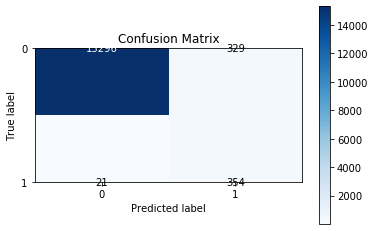

In [177]:
# Importing a library to plot confusion matrix
from sklearn.metrics import confusion_matrix, roc_curve
import scikitplot as skplt

y_pred_proba = clf_rf_best.predict_proba(test_impMedian)
# the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf_best).ravel()
# visualizing the matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred_rf_best, normalize=False)
plt.show()

Afterwards we create a loop over these values to find the best threshold for the minimal cost:

In [178]:
# Finding the best threshold

scores = clf_rf_best.predict_proba(test_impMedian)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, scores)

# Algorithm to find the best threshold
min_cost = np.inf
best_threshold = 0.5
costs = []
for threshold in thresholds:
    y_pred_threshold = scores > threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_threshold).ravel()
    cost = 10*fp + 500*fn
    costs.append(cost)
    if cost < min_cost:
        min_cost = cost
        best_threshold = threshold

print("========================================================")  
print("Best threshold: {:.4f}".format(best_threshold))
print("========================================================")  
print("Min cost: {:.2f}".format(min_cost))
print("========================================================")  
y_pred_test_final = clf_rf_best.predict_proba(test_impMedian)[:,1] > best_threshold
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test_final).ravel()
print("Total cost = ",10*fp + 500*fn)
print("========================================================")  

Best threshold: 0.2244
Min cost: 9050.00
Total cost =  9050


##PCA to perform dimensionality reduction

In [206]:
#Performing standardization and PCA for dimensionality reduction

train_impMedian_pca = train_impMedian

test_impMedian_pca = test_impMedian



In [208]:
train_impMedian_pca.drop(['class'],axis =1, inplace= True)

In [211]:
train_impMedian_pca_std = std.fit_transform(train_impMedian_pca)

train_pca = PCA(n_components= 162, random_state=42)

train_pca.fit_transform(train_impMedian_pca_std)

array([[ 2.37010912e+00, -1.17331635e+00,  1.89963208e+00, ...,
         2.03006607e-07,  2.63175544e-07,  2.40781762e-16],
       [-6.20365710e-01, -5.52837052e-01,  6.90598256e-02, ...,
         2.91868763e-07, -2.09686217e-08, -2.75169092e-16],
       [-1.21199549e+00, -1.10977893e-01, -2.37763392e-01, ...,
        -4.58062273e-08, -4.32997398e-08, -2.57547941e-18],
       ...,
       [-3.20653905e+00,  1.33576140e-01, -7.53515906e-01, ...,
        -2.53788871e-08,  2.55166410e-09,  8.02397661e-19],
       [ 2.38002521e+00, -2.56438900e+00,  2.15057350e+00, ...,
        -5.19715046e-07,  1.79600688e-07,  8.02035386e-18],
       [-7.30547648e-01, -4.38124835e-01,  3.00520679e-01, ...,
        -5.67533155e-08,  2.18150194e-08,  1.12647118e-18]])

<function matplotlib.pyplot.show(*args, **kw)>

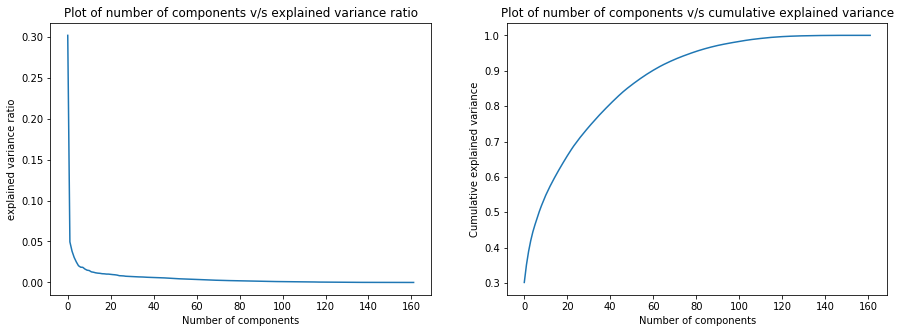

In [212]:
# Plot of number of features v/s explained variance ratio.
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.lineplot(data=train_pca.explained_variance_ratio_)
plt.xlabel("Number of components")
plt.ylabel("explained variance ratio")
plt.title("Plot of number of components v/s explained variance ratio")
plt.subplot(1,2,2)
sns.lineplot(data=np.cumsum(train_pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Plot of number of components v/s cumulative explained variance")
plt.show

In [214]:
print("With Number of components as 90, the cumulative explained variance ratio is " ,train_pca.explained_variance_ratio_[:90].sum())

With Number of components as 90, the cumulative explained variance ratio is  0.9699427596876562


In [215]:
# PCA 90 to the test data

# — Вектор средних: mean_ 
# — Вектор(матрица) проекции: components_
# — Дисперсии осей проекции (выборочная): explained_variance_
# — Доля информации (доля от общей дисперсии): explained_variance_ratio_

pca_90 = PCA(n_components=90,random_state=42)
train_pca_90= pca_90.fit_transform(train_impMedian_pca_std)

In [241]:
# PCA 90 to the test data
test_impMedian_pca_std = std.transform(test_impMedian_pca)
test_pca_90 = pca_90.transform(test_impMedian_pca_std)

In [242]:
train_pca_90.shape

(60000, 90)

In [243]:
test_pca_90.shape

(16000, 90)

In [244]:
# Converting PCA datasets into pandasDataFrame

data_train_pca = pd.DataFrame(train_pca_90)
data_test_pca = pd.DataFrame(test_pca_90)
data_train_pca['class'] = y_train

In [220]:
data_train_pca

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,class
0,2.370109,-1.173316,1.899632,-0.060217,0.750227,-0.398510,0.005013,-0.348747,-1.358151,-0.942023,...,-0.076432,0.080448,-0.152829,-0.195677,0.355385,0.474973,-0.246007,0.196335,-0.233134,0
1,-0.620366,-0.552837,0.069060,-0.117032,0.053238,-0.171587,-0.008235,0.182777,0.313260,-0.174577,...,0.241501,-0.697292,-0.434997,0.267892,0.522477,-0.202712,0.106631,-0.140557,0.171982,0
2,-1.211995,-0.110978,-0.237763,-0.146611,0.243909,0.071734,-0.014483,-0.155625,0.054439,0.481591,...,-0.052130,0.019220,-0.006696,-0.058712,-0.026647,-0.043633,0.024927,0.008089,0.048154,0
3,-3.194907,0.224803,-0.761693,0.264186,-0.154487,0.237237,-0.023598,0.563016,0.939585,0.851131,...,-0.059408,0.026219,0.004079,-0.046590,0.102783,0.095767,-0.017129,0.010416,-0.009878,0
4,0.317832,-0.099276,0.843198,-0.577345,0.214998,-0.070135,0.011107,-0.519220,-1.079806,-0.785511,...,-0.091844,-0.246854,0.264467,-0.035927,0.145477,0.203716,0.016135,0.209443,-0.272606,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,4.849181,-1.399435,1.786845,-1.534255,1.091471,-0.800908,0.034732,-1.171645,-1.471230,-2.114255,...,0.430979,-0.893589,0.445336,0.007191,0.109027,0.837183,0.254864,-0.279281,-0.569742,0
59996,-3.088203,0.135819,-0.635245,0.244558,-0.010281,0.131735,-0.021654,0.380460,0.416913,0.495307,...,0.023544,0.057154,0.005113,0.043334,-0.030338,-0.185508,-0.049195,-0.000632,0.069320,0
59997,-3.206539,0.133576,-0.753516,0.282510,-0.052276,0.172372,-0.025683,0.476513,0.669375,0.702593,...,0.004530,0.069086,0.019818,0.038162,-0.042004,-0.187266,-0.078487,-0.009839,0.017602,0
59998,2.380025,-2.564389,2.150574,-0.184422,1.303254,-1.590321,-0.024381,-0.102139,-0.043580,0.563106,...,0.349703,0.086342,-0.339992,1.048127,-0.751896,0.509735,1.853137,-0.097251,0.481328,0


In [221]:
# Downsampling the negative class
train_neg_sampled_pca = data_train_pca[data_train_pca['class'] == 0].sample(n = 15000,random_state = 42)
train_Sampled_pca = data_train_pca[data_train_pca['class'] == 1].append(train_neg_sampled_pca)

In [222]:
print("Shape of the train data after under sampling the negative class", train_Sampled_pca.shape[0])

Shape of the train data after under sampling the negative class 16000


In [223]:
y_train_Sampled_pca = train_Sampled_pca['class']
train_Sampled_pca.drop(['class'],axis = 1, inplace= True)

In [224]:
# Upsampling the positive class to have a balanced dataset

sm = over_sampling.SMOTE(ratio= 1.0)
train_Sampled_pca_Smote, y_train_Sampled_pca = sm.fit_sample(train_Sampled_pca,y_train_Sampled_pca)

In [225]:
print("Shape of train data after upsampling the positive class by smote", train_Sampled_pca_Smote.shape)


Shape of train data after upsampling the positive class by smote (30000, 90)


Perfom RandomForest GridSearchCV to find the best, model after using PCA

In [227]:
# model fitting and hyperparamter tunning
clf_rf_pca = RandomForestClassifier()

params_pca ={
     'n_estimators':[10,20, 50, 70, 100, 150, 200, 250, 300, 500],
     'max_depth':[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion':['gini', 'entropy']
}
cv = KFold(n_splits=5)
model_pca=GridSearchCV(clf_rf_pca, param_grid=params_pca, verbose=10, n_jobs=-1, scoring= 'f1',cv=cv)
model_pca.fit(train_Sampled_pca_Smote, y_train_Sampled_pca)
print("Best estimator is", model_pca.best_params_)

Fitting 5 folds for each of 780 candidates, totalling 3900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4

Best estimator is {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 70}


In [245]:
#Let's see CV f1 score on Random Forest after PCA perfomance

print("Best parameter (CV f1 random forest pca score=%0.3f):" % model_pca.best_score_)

Best parameter (CV f1 random forest pca score=0.774):


In [270]:
print("\n========================================================")
print(" Results from Grid Search RandomForest PCA best model" )
print("========================================================") 
clf_rf_best_pca = model_pca.best_estimator_
clf_rf_best_pca.fit(train_Sampled_pca_Smote, y_train_Sampled_pca)
y_pred_rf_best_pca = clf_rf_best_pca.predict(data_test_pca)
 
print(classification_report(y_test,y_pred_rf_best_pca))


 Results from Grid Search RandomForest PCA best model
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     15625
           1       0.47      0.96      0.64       375

    accuracy                           0.97     16000
   macro avg       0.74      0.97      0.81     16000
weighted avg       0.99      0.97      0.98     16000



In [271]:
con_mat =confusion_matrix (y_test,y_pred_rf_best_pca)
# Results from GridSearchCV
print("\n========================================================")
print(" Results from Grid Search RandomForest PCA best model" )
print("========================================================")  
print('Confusion Matrix: ', '\n',con_mat)
print("========================================================")  
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("========================================================")  
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("========================================================")  


 Results from Grid Search RandomForest PCA best model
Confusion Matrix:  
 [[15226   399]
 [   14   361]]
Type 1 error (False Positive) =  399
Type 2 error (False Negative) =  14
Total cost =  10990


And again, as it was said, Random forests are a supervised algorithm, meaning that its very likely we’ll have to tune the knobs on our model to see any improvement. We use scikit’s roc_curve function to find all the possible thresholds after PCA perfomance and finding the best Random Forest model.

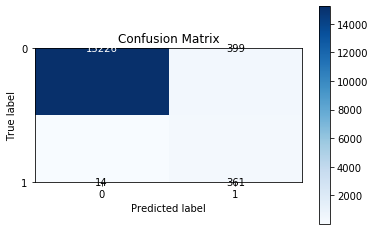

In [272]:
# Importing a library to plot confusion matrix
from sklearn.metrics import confusion_matrix, roc_curve
import scikitplot as skplt

y_pred_proba = clf_rf_best_pca.predict_proba(data_test_pca)
# the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf_best_pca).ravel()
# visualizing the matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred_rf_best_pca, normalize=False)
plt.show()

Then we create a loop over these values to find the best threshold for the minimal cost:

In [275]:
# Finding the best threshold

scores = clf_rf_best_pca.predict_proba(data_test_pca)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, scores)

# Algorithm to find the best threshold
min_cost = np.inf
best_threshold = 0.5
costs = []
for threshold in thresholds:
    y_pred_threshold = scores > threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_threshold).ravel()
    cost = 10*fp + 500*fn
    costs.append(cost)
    if cost < min_cost:
        min_cost = cost
        best_threshold = threshold
print("========================================================")  
print("Best threshold: {:.4f}".format(best_threshold))
print("========================================================")  
print("Min cost: {:.2f}".format(min_cost))
print("========================================================")  
y_pred_test_final_pca = clf_rf_best_pca.predict_proba(data_test_pca)[:,1] > best_threshold
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test_final_pca).ravel()
print("Total cost = ",10*fp + 500*fn)
print("========================================================")  

Best threshold: 0.3383
Min cost: 9900.00
Total cost =  9900


In [332]:
proverka = RandomForestClassifier(n_estimators=70, max_depth=12, criterion='entropy', max_features='auto', random_state=42)

In [333]:
proverka.fit(train_Sampled_pca_Smote, y_train_Sampled_pca)
y_pred_proverka = proverka.predict(data_test_pca)

In [334]:
con_mat =confusion_matrix(y_test,y_pred_proverka)
# Results from GridSearchCV
print("\n========================================================")
print(" Results from Grid Search RandomForest PCA best model" )
print("========================================================")  
print('Confusion Matrix: ', '\n',con_mat)
print("========================================================")  
print("Type 1 error (False Positive) = ", con_mat[0][1])
print("Type 2 error (False Negative) = ", con_mat[1][0])
print("========================================================")  
print("Total cost = ", con_mat[0][1] * 10 + con_mat[1][0] * 500)
print("========================================================")  


 Results from Grid Search RandomForest PCA best model
Confusion Matrix:  
 [[15193   432]
 [   12   363]]
Type 1 error (False Positive) =  432
Type 2 error (False Negative) =  12
Total cost =  10320


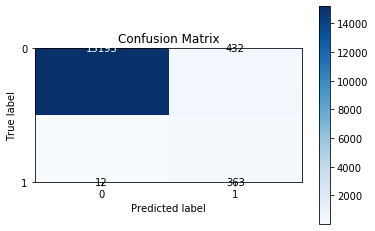

In [335]:
y_pred_proba = proverka.predict_proba(data_test_pca)
# the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_proverka).ravel()
# visualizing the matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred_proverka, normalize=False)
plt.show()

In [336]:
# Finding the best threshold

scores = proverka.predict_proba(data_test_pca)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, scores)

# Algorithm to find the best threshold
min_cost = np.inf
best_threshold = 0.5
costs = []
for threshold in thresholds:
    y_pred_threshold = scores > threshold
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_threshold).ravel()
    cost = 10*fp + 500*fn
    costs.append(cost)
    if cost < min_cost:
        min_cost = cost
        best_threshold = threshold
print("========================================================")  
print("Best threshold: {:.4f}".format(best_threshold))
print("========================================================")  
print("Min cost: {:.2f}".format(min_cost))
print("========================================================")  
y_pred_test_final_pr = proverka.predict_proba(data_test_pca)[:,1] > best_threshold
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test_final_pr).ravel()
print("Total cost = ",10*fp + 500*fn)
print("========================================================")  

Best threshold: 0.4281
Min cost: 9190.00
Total cost =  9190
